In [ ]:
def generate_reward(true_reward, corruption_prob, noise_var, corrupt_value=-100000.0):
    """
    Returns the observed reward:
    - with probability `corruption_prob`, returns a corrupted reward (e.g., a large negative spike),
    - otherwise returns the true reward with Gaussian noise added.
    """
    if np.random.rand() < corruption_prob:
        return corrupt_value
    else:
        return true_reward + np.random.normal(0, noise_var)


<>:110: SyntaxWarning: invalid escape sequence '\m'
<>:110: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3605939280.py:110: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(title='$\mathbf{Robust \quad Async-RAQ}$', fontsize=20,title_fontsize=20)


p = 1 done
p = 2 done
p = 5 done


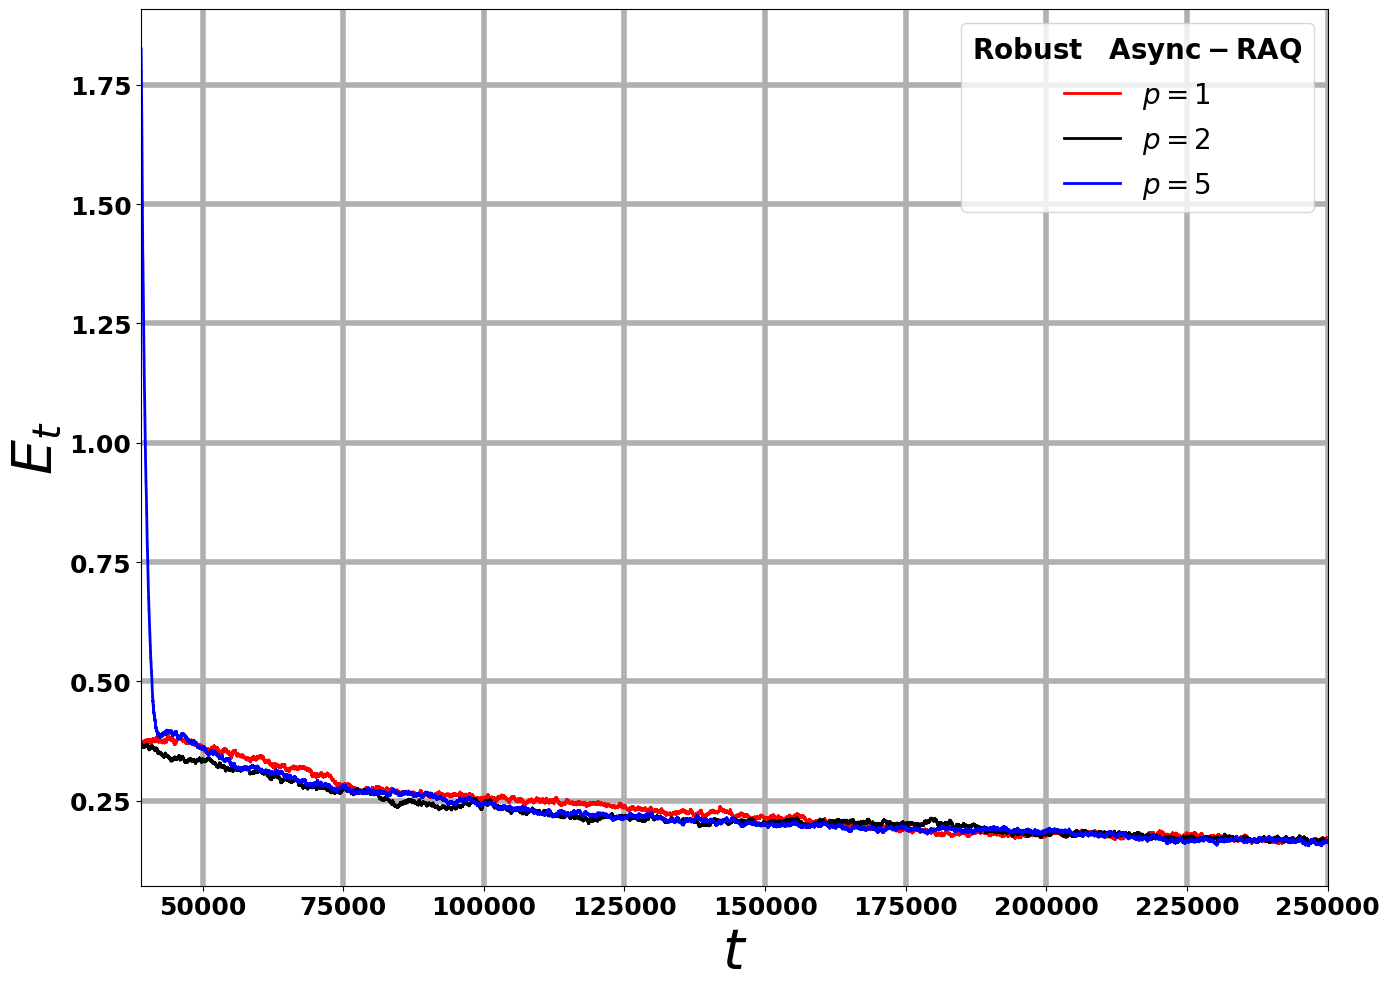

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------- Trimmed Mean Estimator -------------------------

def trimmed_mean_estimator(data, epsilon, delta):
    M = len(data)
    if M < 2:
        return np.mean(data) if M > 0 else 0.0
    if M % 2 != 0:
        data = data[:-1]
        M -= 1

    np.random.shuffle(data)
    D1, D2 = np.split(data, 2)
    D1_sorted = np.sort(D1)
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M

    lower_idx = int(np.floor(zeta * len(D1_sorted)))
    upper_idx = int(np.floor((1 - zeta) * len(D1_sorted)) - 1)
    lower_idx = max(0, min(lower_idx, len(D1_sorted) - 1))
    upper_idx = max(0, min(upper_idx, len(D1_sorted) - 1))

    alpha = D1_sorted[lower_idx]
    beta = D1_sorted[upper_idx]
    phi = lambda x: np.clip(x, alpha, beta)
    trimmed = phi(D2)

    return (2 / M) * np.sum(trimmed)

# ----------------------------- Load Data --------------------------------------
data = np.load('Qlearn_data_new.npz')
P = data['P']         # shape: (S, S, A)
R = data['R']         # shape: (S, A)
Qopt = data['Qopt']   # optimal Q-function
gamma = data['gamma'].item()
S = data['S'].item()
A = data['A'].item()
p = data['p']
p_hat = np.min(p)

# ----------------------------- Hyperparameters --------------------------------
T = 250000
G = 20
alpha = 0.05
epsilon = 0.0001
delta = 0.1
C = 1.1
q_values = [1,2,5]

# ----------------------------- Main Loop for Different q ----------------------
results = {}

for q in q_values:
    delta_modified = (delta**2) / (320000 * (T**(2 * q + 3)))
    T_lim = (104 / (3 * p_hat)) * np.log((200 * T) / delta_modified) + 1
    # Define G_t with current q
    def G_t(t):
        if t <= T_lim:
            return 0.0
        else:
            return C * (t**q) * (np.sqrt((4 * np.log(4 / delta_modified)) / (3 * p_hat * t)) + np.sqrt(epsilon)) + (t**q)

    E = np.zeros(T)

    for g in range(G):
        Q = np.zeros((S, A))
        Err = np.zeros(T)
        s_t = 0
        D = defaultdict(list)

        for t in range(T):
            a_t = np.random.randint(A)
            s_tp1 = np.random.choice(S, p=P[s_t, :, a_t])

            reward = R[s_t, a_t]+np.random.normal(0, 1)
            y_t = generate_reward(R[s_t, a_t], corruption_prob=epsilon, noise_var=5.0)


            D[(s_t, a_t)].append(y_t)

            r_bar = np.median(np.array(D[(s_t, a_t)]))

            r_tilde = 0.0 if abs(r_bar) > G_t(t) else r_bar

            Q[s_t, a_t] = (1 - alpha) * Q[s_t, a_t] + alpha * (r_tilde + gamma * np.max(Q[s_tp1, :]))

            Err[t] = np.max(np.abs(Q - Qopt))

            s_t = s_tp1

        E += Err

    E /= G
    results[q] = E
    print(f"p = {q} done")
# ----------------------------- Plotting ---------------------------------------
plt.figure(figsize=(14, 10))
colors = ['red', 'black', 'blue']
for i, q in enumerate(q_values):
    plt.plot(results[q], label=fr'$p = {q}$', linewidth=4, color=colors[i])

plt.xlim([T_lim, T])
plt.grid(True,linewidth=4)
plt.xlabel(r'$t$', fontsize=40, fontweight='bold')
plt.ylabel(r'$E_t$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(title='$\mathbf{Robust \quad Async-RAQ}$', fontsize=20,title_fontsize=20)
plt.tight_layout()
plt.show()
# ----------------------------- Save Error Data -------------------------------



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------- Trimmed Mean Estimator -------------------------

def trimmed_mean_estimator(data, epsilon, delta):
    M = len(data)
    if M < 2:
        return np.mean(data) if M > 0 else 0.0
    if M % 2 != 0:
        data = data[:-1]
        M -= 1

    np.random.shuffle(data)
    D1, D2 = np.split(data, 2)
    D1_sorted = np.sort(D1)
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M

    lower_idx = int(np.floor(zeta * len(D1_sorted)))
    upper_idx = int(np.floor((1 - zeta) * len(D1_sorted)) - 1)
    lower_idx = max(0, min(lower_idx, len(D1_sorted) - 1))
    upper_idx = max(0, min(upper_idx, len(D1_sorted) - 1))

    alpha = D1_sorted[lower_idx]
    beta = D1_sorted[upper_idx]
    phi = lambda x: np.clip(x, alpha, beta)
    trimmed = phi(D2)

    return (2 / M) * np.sum(trimmed)

# ----------------------------- Load Data --------------------------------------
data = np.load('Qlearn_data_new.npz')
P = data['P']         # shape: (S, S, A)
R = data['R']         # shape: (S, A)
Qopt = data['Qopt']   # optimal Q-function
gamma = data['gamma'].item()
S = data['S'].item()
A = data['A'].item()
p = data['p']
p_hat = np.min(p)

# ----------------------------- Hyperparameters --------------------------------
T = 250000
G = 20
alpha = 0.05
epsilon = 0.0001
delta = 0.1
C = 1.1
q_values = [1,2,5]

# ----------------------------- Main Loop for Different q ----------------------
results = {}

for q in q_values:
    delta_modified = (delta**2) / (320000 * (T**(2 * q + 3)))
    T_lim = (104 / (3 * p_hat)) * np.log((200 * T) / delta_modified) + 1
    # Define G_t with current q
    def G_t(t):
        if t <= T_lim:
            return 0.0
        else:
            return C * (t**q) * (np.sqrt((4 * np.log(4 / delta_modified)) / (3 * p_hat * t)) + np.sqrt(epsilon)) + (t**q)

    E = np.zeros(T)

    for g in range(G):
        Q = np.zeros((S, A))
        Err = np.zeros(T)
        s_t = 0
        D = defaultdict(list)

        for t in range(T):
            a_t = np.random.randint(A)
            s_tp1 = np.random.choice(S, p=P[s_t, :, a_t])

            reward = R[s_t, a_t]+np.random.normal(0, 1)
            y_t = generate_reward(R[s_t, a_t], corruption_prob=epsilon, noise_var=1.0)


            D[(s_t, a_t)].append(y_t)

            r_bar = np.median(np.array(D[(s_t, a_t)]))

            r_tilde = 0.0 if abs(r_bar) > G_t(t) else r_bar

            Q[s_t, a_t] = (1 - alpha) * Q[s_t, a_t] + alpha * (r_tilde + gamma * np.max(Q[s_tp1, :]))

            Err[t] = np.max(np.abs(Q - Qopt))

            s_t = s_tp1

        E += Err

    E /= G
    results[q] = E
    print(f"p = {q} done")
# ----------------------------- Plotting ---------------------------------------
plt.figure(figsize=(14, 10))
colors = ['red', 'black', 'blue']
for i, q in enumerate(q_values):
    plt.plot(results[q], label=fr'$p = {q}$', linewidth=4, color=colors[i])

plt.xlim([0, T])
plt.grid(True,linewidth=4)
plt.xlabel(r'$t$', fontsize=40, fontweight='bold')
plt.ylabel(r'$E_t$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(title='$\mathbf{Robust \quad Async-RAQ}$', fontsize=20,title_fontsize=20)
plt.tight_layout()
plt.show()
# ----------------------------- Save Error Data -------------------------------



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ----------------------------- Repro & I/O ------------------------------------
np.random.seed(123)
os.makedirs("errors_by_run", exist_ok=True)

# ----------------------------- Robust Reward Gen ------------------------------
def generate_reward(mean_reward, corruption_prob=0.0, noise_var=1.0, attack_value=-1.0e4, rng=None):
    """
    Gaussian inlier noise with variance noise_var; with prob 'corruption_prob'
    replace with adversarial 'attack_value'.
    """
    rng = np.random.default_rng() if rng is None else rng
    if rng.random() < corruption_prob:
        return float(attack_value)
    return float(mean_reward + rng.normal(0.0, np.sqrt(noise_var)))

# ----------------------------- Trimmed Mean (unused here) ---------------------
def trimmed_mean_estimator(data, epsilon, delta):
    """
    Two-split clipped-mean (kept for reference; your main loop uses median).
    """
    data = np.asarray(data, dtype=float)
    M = len(data)
    if M < 2:
        return data.mean() if M > 0 else 0.0
    if M % 2 != 0:
        data = data[:-1]
        M -= 1

    data = data.copy()
    np.random.shuffle(data)
    D1, D2 = np.split(data, 2)
    D1_sorted = np.sort(D1)
    zeta = 8 * epsilon + 24 * np.log(4 / delta) / M

    lower_idx = int(np.floor(zeta * len(D1_sorted)))
    upper_idx = int(np.floor((1 - zeta) * len(D1_sorted)) - 1)
    lower_idx = max(0, min(lower_idx, len(D1_sorted) - 1))
    upper_idx = max(0, min(upper_idx, len(D1_sorted) - 1))

    alpha = D1_sorted[lower_idx]
    beta  = D1_sorted[upper_idx]
    trimmed = np.clip(D2, alpha, beta)

    return (2.0 / M) * np.sum(trimmed)

# ----------------------------- Load Data --------------------------------------
data = np.load('Qlearn_data_new.npz', allow_pickle=True)
P     = data['P']         # (S, S, A)
R     = data['R']         # (S, A)
Qopt  = data['Qopt']      # (S, A)
gamma = data['gamma'].item()
S     = data['S'].item()
A     = data['A'].item()
p     = data['p']
p_hat = float(np.min(p))

# ----------------------------- Hyperparameters --------------------------------
T        = 250_000
G        = 20
alpha    = 0.05
epsilon  = 1e-4
delta    = 0.1
C        = 1.1
q_values = [1, 2, 5]

# ----------------------------- Storage ----------------------------------------
# errors_per_q shape: (len(q_values), G, T)
errors_per_q   = np.zeros((len(q_values), G, T), dtype=float)
avg_errors_q   = np.zeros((len(q_values), T), dtype=float)
rng_master     = np.random.default_rng(20250904)

# ----------------------------- Main Loop --------------------------------------
for qi, q in enumerate(q_values):
    # delta_modified & T_lim depend on q
    delta_modified = (delta**2) / (320000 * (T**(2 * q + 3)))
    T_lim = (104.0 / (3.0 * p_hat)) * np.log((200.0 * T) / delta_modified) + 1.0

    def G_t(t):
        if t <= T_lim:
            return 0.0
        term = np.sqrt((4.0 * np.log(4.0 / delta_modified)) / (3.0 * p_hat * max(t, 1.0))) + np.sqrt(epsilon)
        return C * (t**q) * term + (t**q)

    # Run G independent trajectories
    for g in range(G):
        rng = np.random.default_rng(rng_master.integers(0, 2**32 - 1))
        Q = np.zeros((S, A), dtype=float)
        Err = np.zeros(T, dtype=float)
        s_t = 0
        D = defaultdict(list)  # buffer per (s,a)

        for t in range(T):
            a_t   = rng.integers(A)
            s_tp1 = rng.choice(S, p=P[s_t, :, a_t])

            # Generate (possibly corrupted) reward with unit inlier variance
            y_t = generate_reward(R[s_t, a_t], corruption_prob=epsilon, noise_var=1.0, rng=rng)

            # Update buffer and compute robust proxy (median)
            D[(s_t, a_t)].append(y_t)
            r_bar = np.median(np.asarray(D[(s_t, a_t)], dtype=float))

            # Thresholding
            r_tilde = 0.0 if abs(r_bar) > G_t(t) else r_bar

            # Q update
            Q[s_t, a_t] = (1.0 - alpha) * Q[s_t, a_t] + alpha * (r_tilde + gamma * np.max(Q[s_tp1, :]))

            # Track sup-norm error
            Err[t] = np.max(np.abs(Q - Qopt))

            s_t = s_tp1

        errors_per_q[qi, g, :] = Err

        # --- Save each run immediately (per your request to save .npy for all G) ---
        np.save(f"errors_by_run/err_q{q}_run{g}.npy", Err)

    # Average over runs
    avg_errors_q[qi, :] = errors_per_q[qi].mean(axis=0)
    print(f"q = {q} done")

# ----------------------------- Save Summary -----------------------------------
# 1) Full tensor of all runs (q x G x T)
np.save("Robust_Async_RAQ_all_runs.npy", errors_per_q)

# 2) Compact summary with metadata
np.savez(
    "Robust_Async_RAQ_summary.npz",
    q_values=np.array(q_values, dtype=int),
    avg_errors=avg_errors_q,         # (len(q_values), T)
    errors_shape=errors_per_q.shape, # (len(q_values), G, T)
    T=T, G=G, alpha=alpha, epsilon=epsilon, delta=delta, C=C,
    gamma=gamma, S=S, A=A, p_hat=p_hat
)

# ----------------------------- Plotting (optional) ----------------------------
plt.figure(figsize=(14, 10))
colors = ['red', 'black', 'blue']
for qi, q in enumerate(q_values):
    plt.plot(avg_errors_q[qi], color=colors[q], linewidth=4, label=fr'$p = {q}$')

plt.xlim([20,000, T])
plt.grid(True, linewidth=3)
plt.xlabel(r'$t$', fontsize=40, fontweight='bold')
plt.ylabel(r'$E_t$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(title=r'$\mathbf{Robust \quad Async\text{-}RAQ}$', fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.show()
